In [1]:
%matplotlib inline
import collections
import glob
import h5py
import os
import re
import warnings
import numpy as np
import matplotlib.gridspec as gridspec
import TwissTable as tt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
madx_folder = "madx_run_V"
plane = "V"

In [8]:
# Function definitions

def gauss(x, a, b, c, d, e):
    return a*np.exp(-(x - b) ** 2 / (2 * c ** 2)) + d * x + e

def scattering_angle(momentum, beta_rel, d, l=18.9e-2):
    # p = momentum of the particles
    # v = speed of the particles
    # d = wire thickness
    # l = radiation length of carbon
    return (13.6 / (momentum * beta_rel)) * np.sqrt((d / l)) * ( 1 + 0.088 * np.log10( d / l))

def get_beta(run, plane):
    data_path = os.path.join("..", "madx", run)
    files = os.listdir(data_path)

    ctimes = []
    beta_x_h = []
    alpha_x_h = []
    beta_y_h = []
    alpha_y_h = []

    beta_x_v = []
    alpha_x_v = []
    beta_y_v = []
    alpha_y_v = []

    for f in files:
        if f.startswith("output"):
            ctime = re.search("R3_(.*)_0", f).group(1)
            file_path = os.path.join(data_path, f)
            tab = tt.TwissTable(file_path)
            tab.convertToNumpy()
            
            ws_h = tab.findDataIndex("NAME", "BR3.BWS.2L1.H_ROT")[0]

            ws_h_betx = tab.data["BETX"][ws_h]
            ws_h_bety = tab.data["BETY"][ws_h]
            ws_h_alphax = tab.data["ALFX"][ws_h]
            ws_h_alphay = tab.data["ALFY"][ws_h]
            ws_h_disp = tab.data["DISP"][ws_h]

            ctimes.append(ctime)
            beta_x_h.append(ws_h_betx)
            alpha_x_h.append(ws_h_alphax)
            beta_y_h.append(ws_h_bety)
            alpha_y_h.append(ws_h_alphay)
            
            
            ws_v = tab.findDataIndex("NAME", "BR3.BWS.2L1.V_ROT")[0]

            ws_v_betx = tab.data["BETX"][ws_v]
            ws_v_bety = tab.data["BETY"][ws_v]
            ws_v_alphax = tab.data["ALFX"][ws_v]
            ws_v_alphay = tab.data["ALFY"][ws_v]
            ws_v_disp = tab.data["DISP"][ws_v]

            beta_x_v.append(ws_v_betx)
            alpha_x_v.append(ws_v_alphax)
            beta_y_v.append(ws_v_bety)
            alpha_y_v.append(ws_v_alphay)
            

    if plane == "H":
        return ctimes, beta_x_h

    elif plane == "V":
        return ctimes, beta_y_v


def apply_fit(function, data_1, data_2, ind_var):
    
    mu_y = max(data_2)
    min_y = min(data_2)
    data_x = []
    data_y = []
    mu_x = []
    for x, y in zip(data_1, data_2):
        if y == mu_y:
            mu_x.append(x)
    for x, y in zip(data_1, data_2):
        if x - mu_x[0] > -20 and x - mu_x[0] < 20:
            data_x.append(x - mu_x[0])
            data_y.append((y - min_y) / mu_y)
    
    if ind_var == "space":
        try:
            popt, pcov = curve_fit(function, np.asarray(data_x), np.asarray(data_y))
            return np.asarray(data_x), np.asarray(data_y), popt, pcov
        except:
            print("")
            print("Fit of profile failed.")
            print("")
            return "NaN", "NaN"
        
        
def calculate_emittance(data_dict, sel_ctime, madx_folder, plane):
    sigma_wire = np.asarray(data_dict["sw"])
    sigma_grid_1 = np.asarray(data_dict["s1"])
    sigma_grid_2 = np.asarray(data_dict["s2"])
    sigma_grid_3 = np.asarray(data_dict["s3"])
    intensity = np.asarray(data_dict["i"])

    int_new = [x if (x > np.mean(intensity) - np.std(intensity)) else 0 for x in intensity]
    int_new = [x if (x < np.mean(intensity) + np.std(intensity)) else 0 for x in int_new]
    print("Recorded intensities:", intensity)
    print("Intensities after outlier exclusion:", int_new)
    
#     norm_sigma_wire = (sigma_wire / intensity) * np.mean(intensity)
#     norm_sigma_grid_1 = (sigma_grid_1 / intensity) * np.mean(intensity)
#     norm_sigma_grid_2 = (sigma_grid_2 / intensity) * np.mean(intensity)
#     norm_sigma_grid_3 = (sigma_grid_3 / intensity) * np.mean(intensity)
    
    ct_ws, beta_ws = get_beta(madx_folder, plane)
    
    fun_beta = interpolate.interp1d(np.asarray(ct_ws, dtype="float64"), beta_ws, kind='linear', fill_value='extrapolate')
    
    beta_wire = fun_beta(sel_ctime)
    print("Beta wire:", beta_wire)
    
    data = h5py.File("../beta_gamma.hdf5", 'r')
    ctime = np.asarray(list(data["ctime"]))
    beta = np.asarray(list(data["beta"]))
    gamma = np.asarray(list(data["gamma"]))
    
    beta_gamma = []
    
    for ct, b, g in zip(ctime, beta, gamma):
        if ct == sel_ctime:
            beta_gamma.append(b)
            beta_gamma.append(g)
            
    beta_rel = beta_gamma[0]    
    gamma_rel = beta_gamma[1]
    
    print("Beta rel:", beta_rel, "Gamma rel:", gamma_rel)
    
#     norm_emittance_wire = ((norm_sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    emittance_wire = ((sigma_wire)**2 / beta_wire) * beta_rel * gamma_rel
    norm_emittance_wire = []
    new_emittance_wire = []
    for e, i in zip(emittance_wire, int_new):
        print(e, i)
        if i != 0:
            n_em = (e/i)*np.mean(int_new)
            norm_emittance_wire.append(n_em)
            new_emittance_wire.append(e)
        else:
            print("An intensity value was excluded.")
    
    print("")
    print("Normal emittance:", new_emittance_wire, np.mean(new_emittance_wire), np.std(new_emittance_wire, dtype=np.float64))
    print("Normalized emittance:", norm_emittance_wire, np.mean(norm_emittance_wire), np.std(norm_emittance_wire, dtype=np.float64))
    print("Intensity:", intensity, np.mean(intensity))
    print("")
    
    e_norm = [x for x in norm_emittance_wire if (x > np.mean(norm_emittance_wire) - 2 * np.std(norm_emittance_wire))]
    e_norm = [x for x in e_norm if (x < np.mean(norm_emittance_wire) + 2 * np.std(norm_emittance_wire))]
   
    print("Outliers excluded:", e_norm, np.mean(e_norm), np.std(e_norm, dtype=np.float64))
          
    return beta_wire, beta_rel, gamma_rel, np.mean(e_norm), np.std(e_norm, dtype=np.float64), np.mean(new_emittance_wire), np.std(new_emittance_wire, dtype=np.float64), np.mean(sigma_wire), np.std(sigma_wire), np.mean(intensity), np.std(intensity)  

def get_data(directory, sel_ctime):
#     plane = re.search('PROFILE_(.*)_2018', directory).group(1).replace("_", " ")
#     beam = re.search('(.*)_PROFILE', directory).group(1)
    bct_files = glob.glob(os.path.join(data_path, directory, "bct_shot*"))
    ws_files = glob.glob(os.path.join(data_path, directory, "wirescanner_shot*"))
    sem_files = glob.glob(os.path.join(data_path, directory, "semgrid_shot*"))
    
    bct_dict = collections.defaultdict(list)
    ws_dict = collections.defaultdict(list)
    sem_dict = collections.defaultdict(list)
    data_dict = collections.defaultdict(list)
    
    shots_bct = []
    shots_ws = []
    shots_sem = []
    
    for fb in bct_files:
        data_bct = h5py.File(fb, 'r')
        x = np.asarray(list(data_bct["ctime"]))
        y = np.asarray(list(data_bct["intensity"]))
        shot_bct = re.search('shot_(.*)_R', fb).group(1)
        shots_bct.append(shot_bct)
        bct_dict[(str(shot_bct), "x")] = x
        bct_dict[(str(shot_bct), "y")] = y
        
    for fw in ws_files:
        data_ws = h5py.File(fw, 'r')
        shot_ws = re.search('shot_(.*)_R', fw).group(1)
        shots_ws.append(shot_ws)
        ws_dict[(str(shot_ws), "x")] = np.asarray(list(data_ws["position"]))
        ws_dict[(str(shot_ws), "y")] = np.asarray(list(data_ws["intensity"]))
        ws_dict[(str(shot_ws), "z")] = np.asarray(list(data_ws["time"]))
        
    for fs in sem_files:
        data_sem = h5py.File(fs, 'r')
        x1 = np.asarray(list(data_sem["sem_1_x"]))
        y1 = np.asarray(list(data_sem["sem_1_y"]))
        x2 = np.asarray(list(data_sem["sem_2_x"]))
        y2 = np.asarray(list(data_sem["sem_2_y"]))
        x3 = np.asarray(list(data_sem["sem_3_x"]))
        y3 = np.asarray(list(data_sem["sem_3_y"]))
        shot_sem = re.search('shot_(.*)_R', fs).group(1)
        shots_sem.append(shot_sem)
        sem_dict[(str(shot_sem), "x1")] = x1
        sem_dict[(str(shot_sem), "y1")] = y1
        sem_dict[(str(shot_sem), "x2")] = x2
#         sem_dict[(str(shot_sem), "y2")] = y2
        sem_dict[(str(shot_sem), "x3")] = x3
        sem_dict[(str(shot_sem), "y3")] = y3
        
        
    shot_list = list(set(shots_bct) & set(shots_ws) & set(shots_sem))

    for shot in shot_list:
        fig = plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        plt.rcParams["figure.figsize"] = [10, 3]
        
        intensity = []
        for x_bct, y_bct in zip(bct_dict[(shot, "x")],  bct_dict[(shot, "y")]):
            if x_bct == sel_ctime:
                intensity.append(y_bct)
        ax1.scatter(bct_dict[(shot, "x")], bct_dict[(shot, "y")], s=0.3, color="black", label=str(intensity[0]))
        ax1.set_xlabel('ctime [ms]')
        ax1.set_ylabel(r'Intensity [$10^{10}$]')
        ax1.legend(fontsize=10, loc="upper right")
        
        x, y, popt, pcov = apply_fit(gauss, ws_dict[(shot, "x")]*1e-3, ws_dict[(shot, "y")], "space")
        perr = np.sqrt(np.diag(pcov))
        fit = r"$\sigma={:.3f}\pm{:.3f}$".format(popt[2], perr[2])
        
        ax2.scatter(x, y, s=0.3, color="black")
        ax2.plot(x, gauss(x, popt[0], popt[1], popt[2], popt[3], popt[4]), label=fit, lw=0.8, color='green')
        ax2.set_xlabel('Position [mm]')
        ax2.set_ylabel(r'Normalized amplitude')
        ax2.set_ylim([-0.05, max(y) + 0.2*max(y)])
        ax2.set_title(str(sel_ctime) + ", shot " + str(shot))
        ax2.legend(fontsize=10, loc="upper left")
        
        x1, y1, popt1, pcov1 = apply_fit(gauss, sem_dict[(shot, "x1")], sem_dict[(shot, "y1")], "space")
        perr1 = np.sqrt(np.diag(pcov1))
        fit1 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt1[2]), perr1[2])
        
        x2, y2, popt2, pcov2 = apply_fit(gauss, sem_dict[(shot, "x2")], sem_dict[(shot, "y2")], "space")
        perr2 = np.sqrt(np.diag(pcov2))
        fit2 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt2[2]), perr2[2])
        
        x3, y3, popt3, pcov3 = apply_fit(gauss, sem_dict[(shot, "x3")], sem_dict[(shot, "y3")], "space")
        perr3 = np.sqrt(np.diag(pcov3))
        fit3 = r"$\sigma={:.3f}\pm{:.3f}$".format(abs(popt3[2]), perr3[2])
        
        ax3.scatter(x1, y1, s=0.5, color='blue')
        ax3.plot(x1, gauss(x1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4]), label="Grid 1: " + fit1, lw=0.8, color='blue')
        ax3.scatter(x2, y2, s=0.5, color='green')
        ax3.plot(x2, gauss(x2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]), label="Grid 2: " + fit2, lw=0.8, color='green')
        ax3.scatter(x3, y3, s=0.5, color='orange')
        ax3.plot(x3, gauss(x3, popt3[0], popt3[1], popt3[2], popt3[3], popt3[4]), label="Grid 3: " + fit3, lw=0.8, color='orange')
        ax3.legend(fontsize=10, loc="upper left")
        
        ax3.set_ylim([-0.05, 2])
        
        ax3.set_xlabel('Position [mm]')
        ax3.set_ylabel(r'Normalized amplitude')
        
#         ax3.plot(sem_dict[(shot, "x1")], sem_dict[(shot, "y1")])
#         ax3.plot(sem_dict[(shot, "x2")], sem_dict[(shot, "y2")])
#         ax3.plot(sem_dict[(shot, "x3")], sem_dict[(shot, "y3")])
        
        plt.tight_layout()
        plt.show()
        
        data_dict["sw"].append(popt[2])
        data_dict["s1"].append(popt1[2])
        data_dict["s2"].append(popt2[2])
        data_dict["s3"].append(popt3[2])
        data_dict["i"].append(intensity[0])
        
    return data_dict

In [33]:
# Specify the folder where the data is with respect to the location of this notebook
data_path = os.path.join(os.getcwd(), "results")

# result_folders = [x[0].strip(data_path) for x in os.walk(data_path)][1:]
result_folders = [d for d in os.listdir(data_path) if os.path.isdir(data_path)]
result_folders.remove('emittance.png')
result_folders.remove('data.txt')

print(result_folders)

['RUN_V_PROFILE_360_V_R3_2018_10_19_15_31', 'RUN_V_PROFILE_375_V_R3_2018_10_19_17_12', 'RUN_V_PROFILE_400_V_R3_2018_10_19_14_58', 'RUN_V_PROFILE_320_V_R3_2018_10_19_13_32', 'RUN_V_PROFILE_330_V_R3_2018_10_19_15_43', 'RUN_V_PROFILE_430_V_R3_2018_10_19_17_23', 'RUN_V_PROFILE_300_V_R3_2018_10_19_16_12', 'RUN_V_PROFILE_310_V_R3_2018_10_19_13_14', 'RUN_V_PROFILE_340_V_R3_2018_10_19_14_24', 'RUN_V_PROFILE_285_V_R3_2018_10_19_12_10', 'RUN_V_PROFILE_350_V_R3_2018_10_19_14_38', 'RUN_V_PROFILE_300_V_R3_2018_10_19_11_56', 'RUN_V_PROFILE_325_V_R3_2018_10_19_15_52', 'RUN_V_PROFILE_500_V_R3_2018_10_19_15_10']



RUN_V_PROFILE_360_V_R3_2018_10_19_15_31


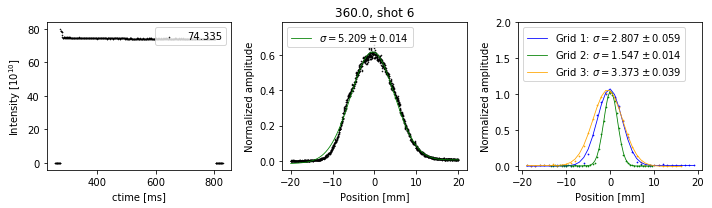

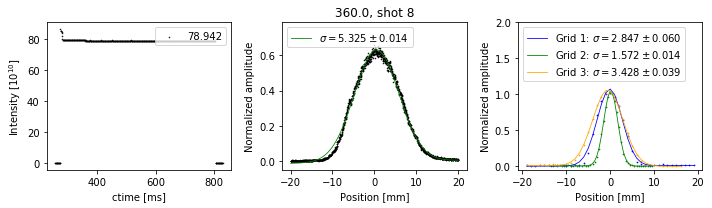

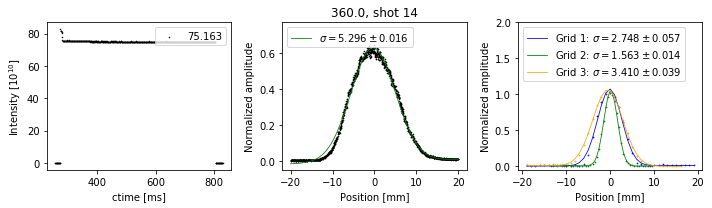

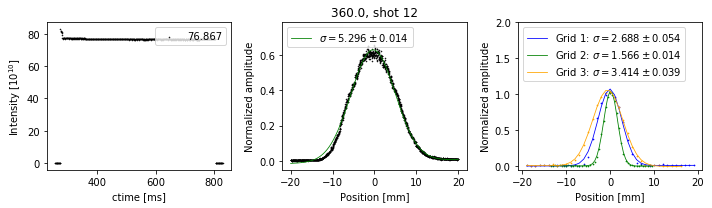

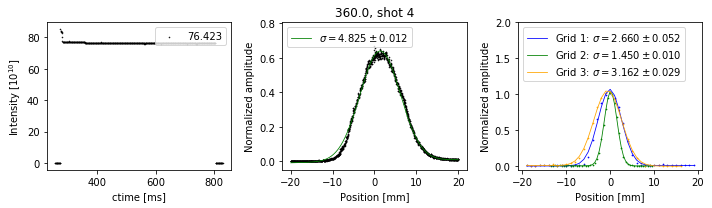

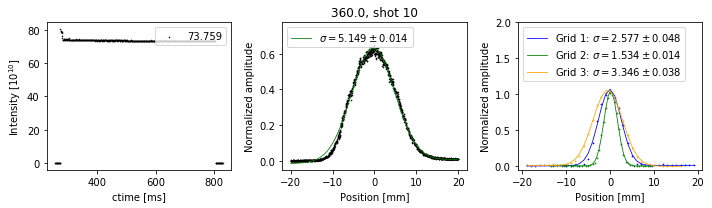

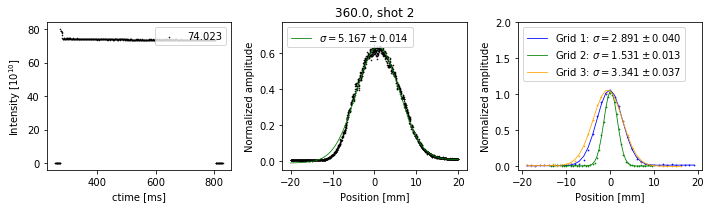

Recorded intensities: [ 74.335  78.942  75.163  76.867  76.423  73.759  74.023]
Intensities after outlier exclusion: [74.335000000000008, 0, 75.162999999999997, 76.867000000000004, 76.423000000000002, 0, 74.022999999999996]
Beta wire: 4.283643597399999
Beta rel: 0.44528 Gamma rel: 1.11683
3.15047063995 74.335
3.29153071377 0
An intensity value was excluded.
3.25602297378 75.163
3.25574477577 76.867
2.7032487301 76.423
3.07784906687 0
An intensity value was excluded.
3.09984748812 74.023

Normal emittance: [3.1504706399496301, 3.2560229737774082, 3.2557447757659133, 2.7032487301047552, 3.0998474881248779] 3.09306692154 0.204116704148
Normalized emittance: [2.2814324963438875, 2.3318944404105344, 2.2800058072498683, 1.9040899378450074, 2.2542349421276855] 2.2103315248 0.15517655485
Intensity: [ 74.335  78.942  75.163  76.867  76.423  73.759  74.023] 75.6445714286

Outliers excluded: [2.2814324963438875, 2.3318944404105344, 2.2800058072498683, 1.9040899378450074, 2.2542349421276855] 2.210

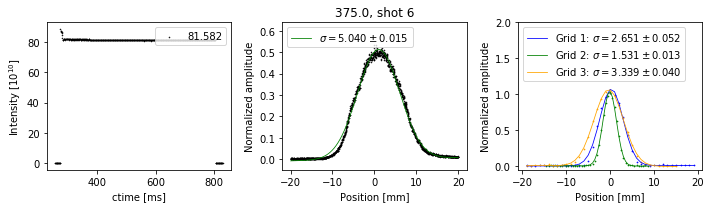

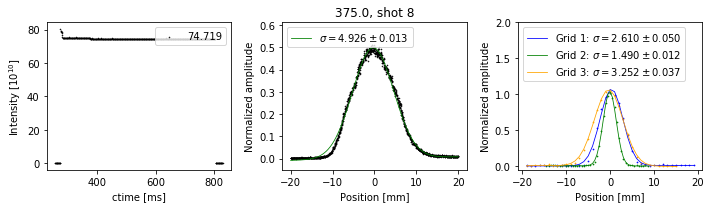

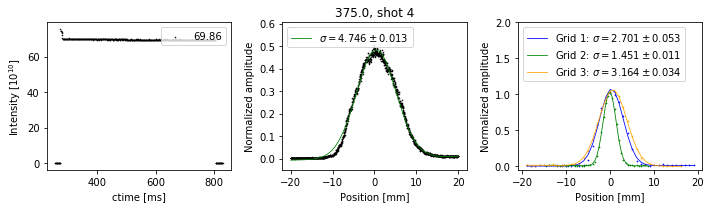

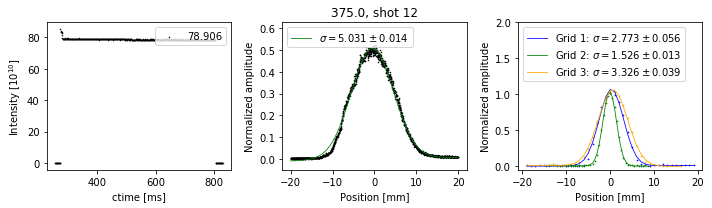

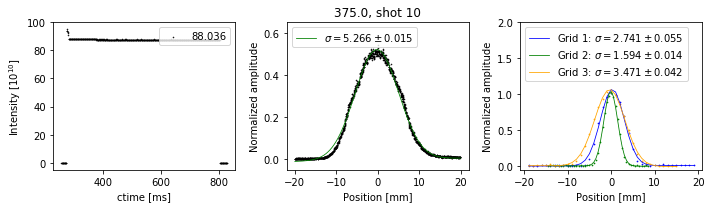

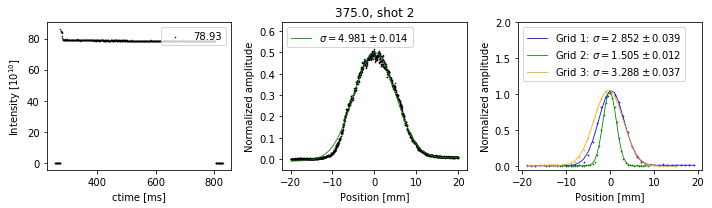

Recorded intensities: [ 81.582  74.719  69.86   78.906  88.036  78.93 ]
Intensities after outlier exclusion: [81.582000000000008, 74.719000000000008, 0, 78.906000000000006, 0, 78.930000000000007]
Beta wire: 4.2827250851
Beta rel: 0.47317 Gamma rel: 1.13511
3.18605534167 81.582
3.0430863064 74.719
2.82424160856 0
An intensity value was excluded.
3.17403877314 78.906
3.47769619009 0
An intensity value was excluded.
3.11210349513 78.93

Normal emittance: [3.1860553416697153, 3.043086306403612, 3.1740387731396416, 3.1121034951300128] 3.12882097909 0.0568997573132
Normalized emittance: [2.0446868730563508, 2.1323135191734175, 2.1060566118287745, 2.0643330707581757] 2.0868475187 0.0343531907728
Intensity: [ 81.582  74.719  69.86   78.906  88.036  78.93 ] 78.6721666667

Outliers excluded: [2.0446868730563508, 2.1323135191734175, 2.1060566118287745, 2.0643330707581757] 2.0868475187 0.0343531907728

RUN_V_PROFILE_400_V_R3_2018_10_19_14_58


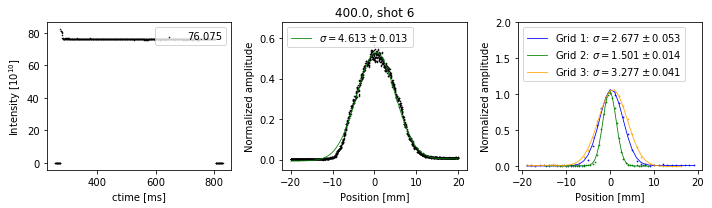

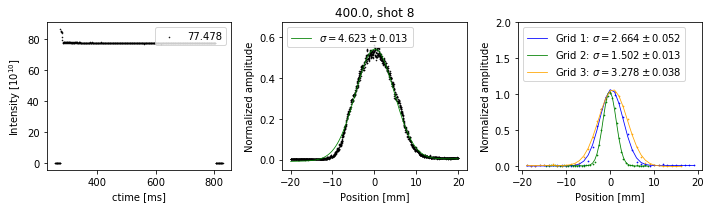

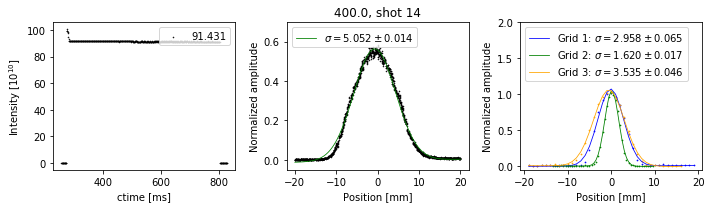

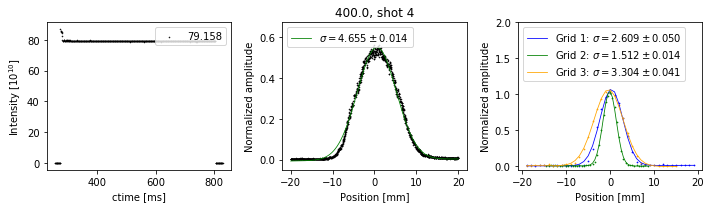

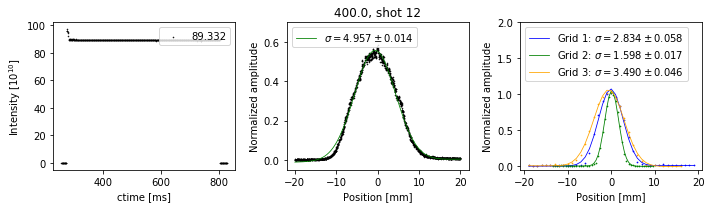

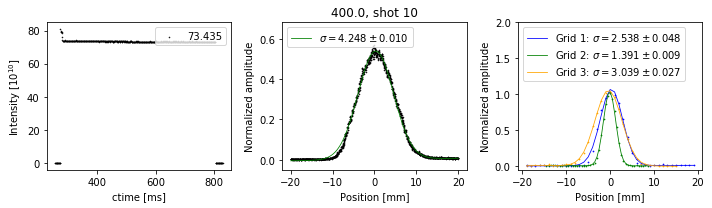

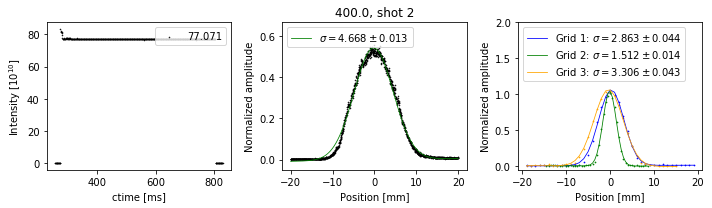

Recorded intensities: [ 76.075  77.478  91.431  79.158  89.332  73.435  77.071]
Intensities after outlier exclusion: [76.075000000000003, 77.478000000000009, 0, 79.158000000000001, 0, 0, 77.070999999999998]
Beta wire: 4.28112442965
Beta rel: 0.52149 Gamma rel: 1.17198
3.03768978251 76.075
3.05157455454 77.478
3.64380089812 0
An intensity value was excluded.
3.09368777491 79.158
3.50779282261 0
An intensity value was excluded.
2.57581010771 0
An intensity value was excluded.
3.11136746819 77.071

Normal emittance: [3.0376897825139331, 3.051574554541852, 3.0936877749124214, 3.1113674681855406] 3.07357989504 0.0300190052499
Normalized emittance: [1.7670937819008146, 1.7430254277805752, 1.7295766266525172, 1.7865634786281541] 1.75656482874 0.0219229119874
Intensity: [ 76.075  77.478  91.431  79.158  89.332  73.435  77.071] 80.5685714286

Outliers excluded: [1.7670937819008146, 1.7430254277805752, 1.7295766266525172, 1.7865634786281541] 1.75656482874 0.0219229119874

RUN_V_PROFILE_320_V_R3_

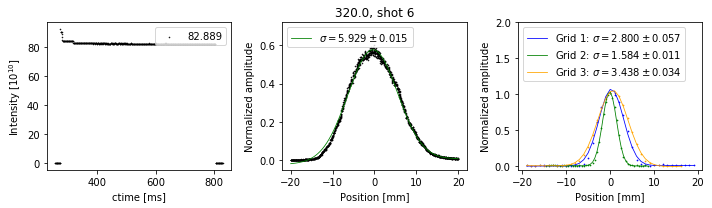

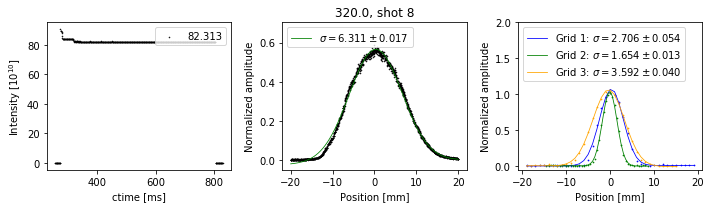

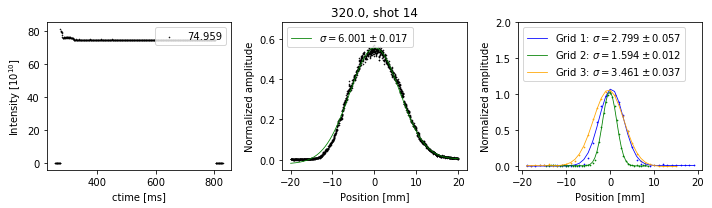

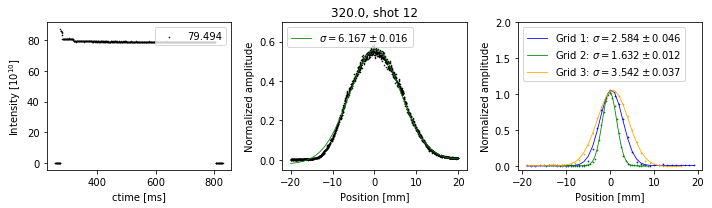

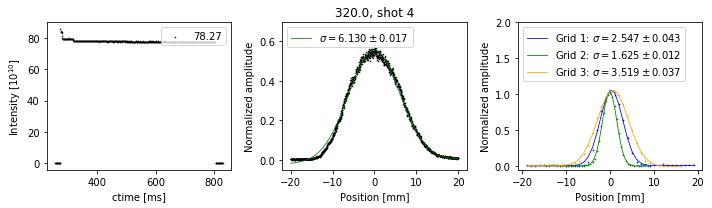

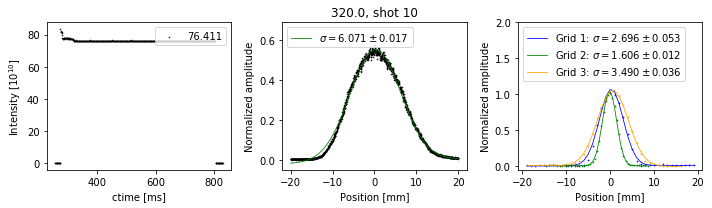

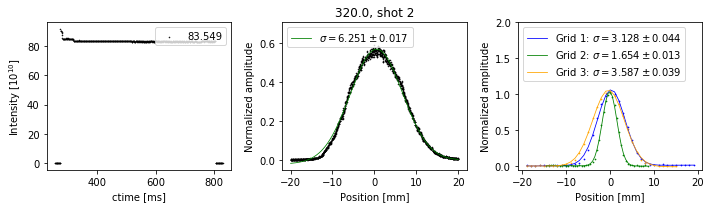

Recorded intensities: [ 82.889  82.313  74.959  79.494  78.27   76.411  83.549]
Intensities after outlier exclusion: [0, 82.313000000000002, 0, 79.494, 78.269999999999996, 0, 0]
Beta wire: 4.2901157337
Beta rel: 0.37581 Gamma rel: 1.0791
3.32296726932 0
An intensity value was excluded.
3.76539160088 82.313
3.4042976688 0
An intensity value was excluded.
3.59541176677 79.494
3.55251164331 78.27
3.48377865911 0
An intensity value was excluded.
3.69345606386 0
An intensity value was excluded.

Normal emittance: [3.7653916008776021, 3.5954117667733012, 3.5525116433063175] 3.63777167032 0.0919247523982
Normalized emittance: [1.5688962850233552, 1.5511964438136101, 1.5566561495739124] 1.5589162928 0.00740055314494
Intensity: [ 82.889  82.313  74.959  79.494  78.27   76.411  83.549] 79.6978571429

Outliers excluded: [1.5688962850233552, 1.5511964438136101, 1.5566561495739124] 1.5589162928 0.00740055314494

RUN_V_PROFILE_330_V_R3_2018_10_19_15_43


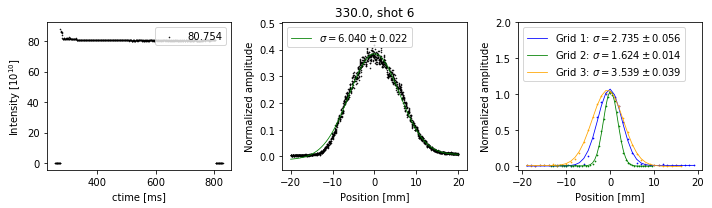

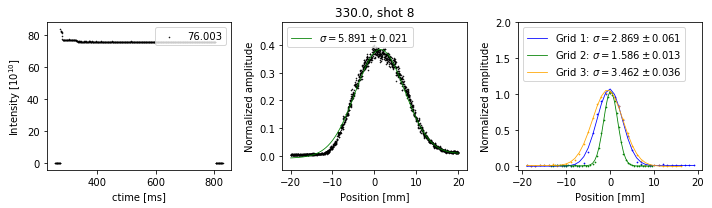

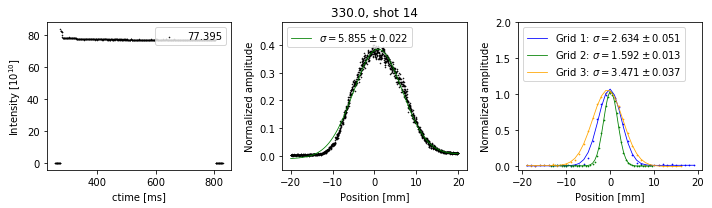

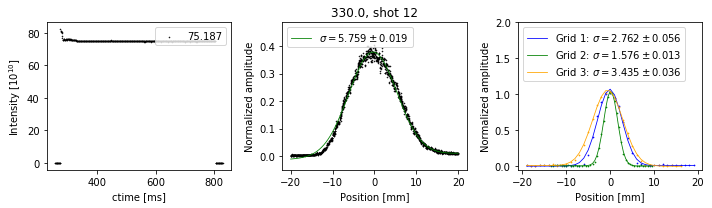

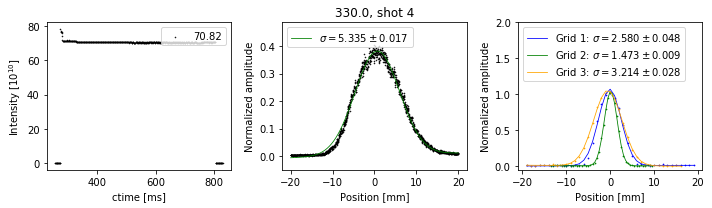

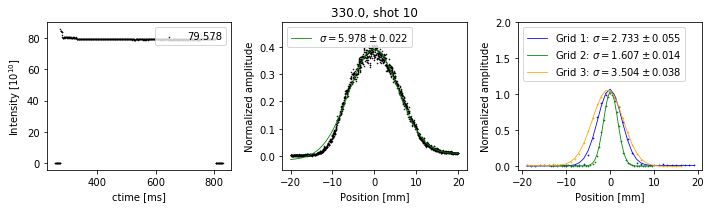

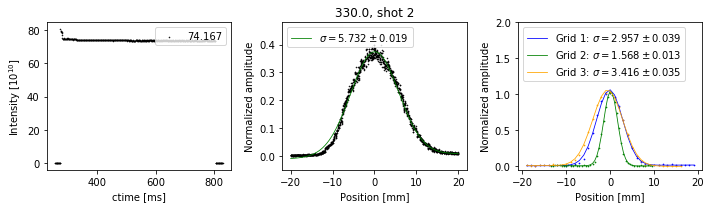

Recorded intensities: [ 80.754  76.003  77.395  75.187  70.82   79.578  74.167]
Intensities after outlier exclusion: [0, 76.003, 77.394999999999996, 75.186999999999998, 0, 0, 74.167000000000002]
Beta wire: 4.2887342465
Beta rel: 0.39244 Gamma rel: 1.08722
3.62981581974 0
An intensity value was excluded.
3.45292205335 76.003
3.41081580042 77.395
3.29903090061 75.187
2.8318922516 0
An intensity value was excluded.
3.55571880219 0
An intensity value was excluded.
3.26833444678 74.167

Normal emittance: [3.4529220533530092, 3.4108158004222866, 3.2990309006082814, 3.2683344467781912] 3.35777580029 0.0763491487225
Normalized emittance: [1.9649206657194549, 1.9060502343441308, 1.8977220667344818, 1.9059204043981648] 1.9186533428 0.0269246613301
Intensity: [ 80.754  76.003  77.395  75.187  70.82   79.578  74.167] 76.272

Outliers excluded: [1.9649206657194549, 1.9060502343441308, 1.8977220667344818, 1.9059204043981648] 1.9186533428 0.0269246613301

RUN_V_PROFILE_430_V_R3_2018_10_19_17_23


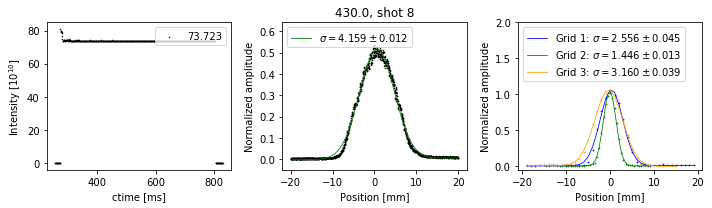

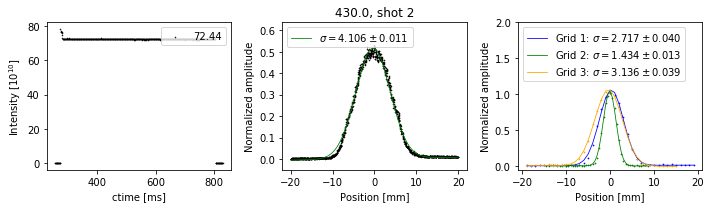

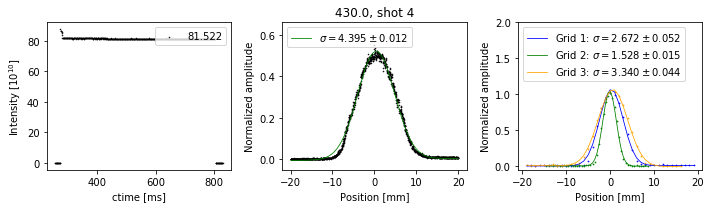

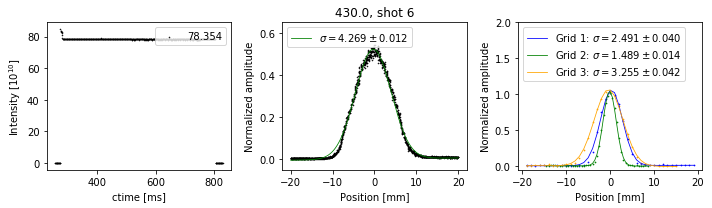

Recorded intensities: [ 73.723  72.44   81.522  78.354]
Intensities after outlier exclusion: [73.722999999999999, 0, 0, 78.353999999999999]
Beta wire: 4.2819629102
Beta rel: 0.58113 Gamma rel: 1.22879
2.88508794053 73.723
2.81146577989 0
An intensity value was excluded.
3.22184922186 0
An intensity value was excluded.
3.03979181551 78.354

Normal emittance: [2.88508794052875, 3.039791815513079] 2.96243987802 0.0773519374922
Normalized emittance: [1.4878515481321659, 1.4749802815675732] 1.48141591485 0.0064356332823
Intensity: [ 73.723  72.44   81.522  78.354] 76.50975

Outliers excluded: [1.4878515481321659, 1.4749802815675732] 1.48141591485 0.0064356332823

RUN_V_PROFILE_300_V_R3_2018_10_19_16_12


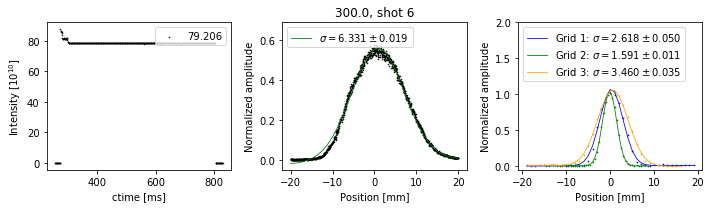

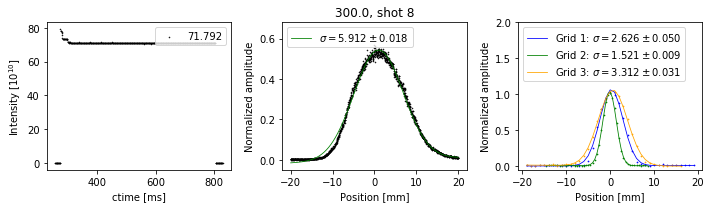

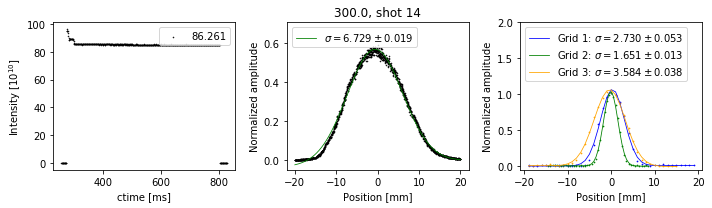

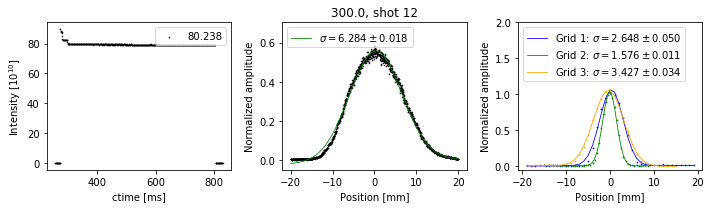

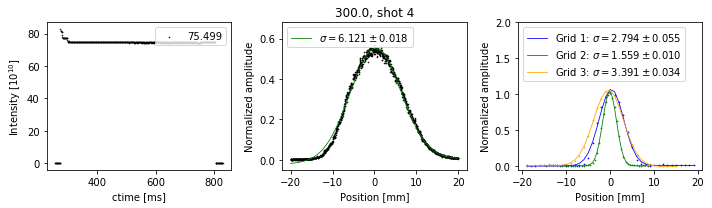

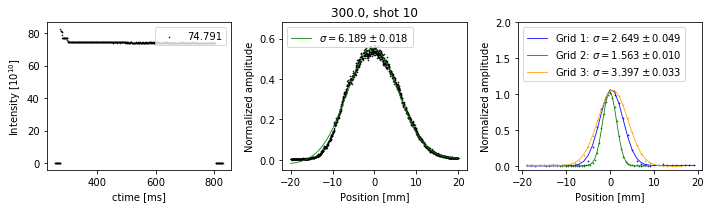

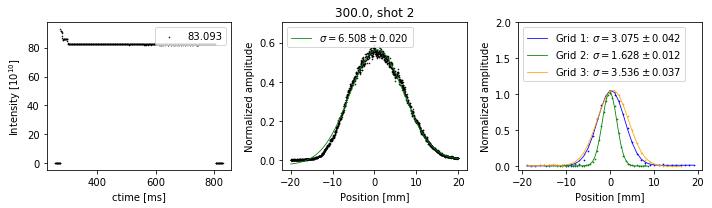

Recorded intensities: [ 79.206  71.792  86.261  80.238  75.499  74.791  83.093]
Intensities after outlier exclusion: [79.206000000000003, 0, 0, 80.238, 75.498999999999995, 74.790999999999997, 83.093000000000004]
Beta wire: 4.29189735005
Beta rel: 0.34446 Gamma rel: 1.06519
3.42613103917 79.206
2.9878492237 0
An intensity value was excluded.
3.87148263366 0
An intensity value was excluded.
3.37581567832 80.238
3.20307325042 75.499
3.27424156015 74.791
3.62043375643 83.093

Normal emittance: [3.4261310391696584, 3.3758156783247766, 3.2030732504195849, 3.2742415601505259, 3.6204337564340507] 3.3799390569 0.143137609524
Normalized emittance: [2.4274437681919832, 2.3610322602209979, 2.3808331534052005, 2.4567709433129861, 2.4451159393497459] 2.4142392129 0.0371042456681
Intensity: [ 79.206  71.792  86.261  80.238  75.499  74.791  83.093] 78.6971428571

Outliers excluded: [2.4274437681919832, 2.3610322602209979, 2.3808331534052005, 2.4567709433129861, 2.4451159393497459] 2.4142392129 0.03710

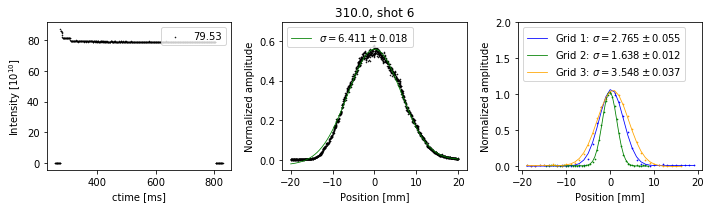

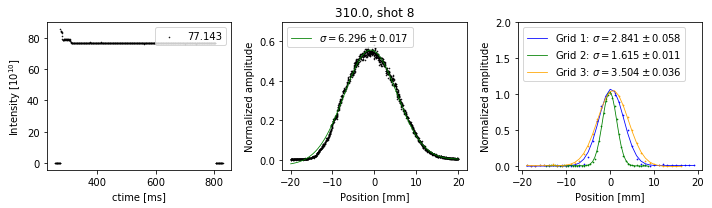

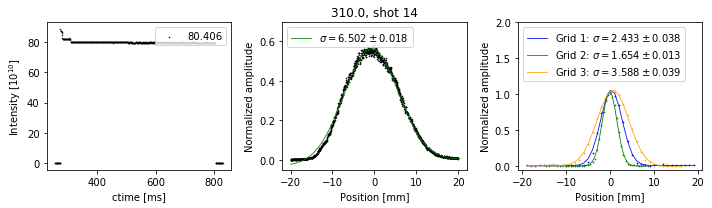

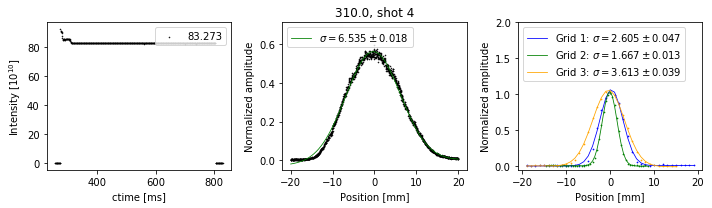

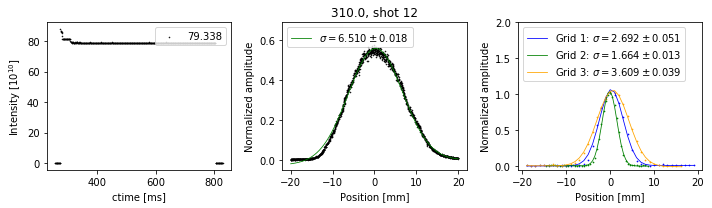

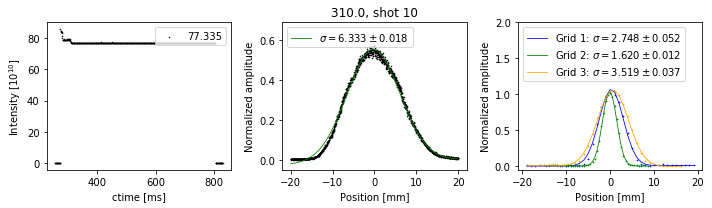

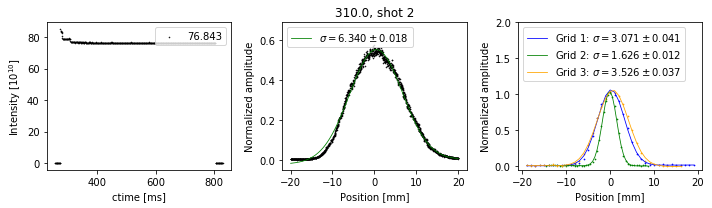

Recorded intensities: [ 79.53   77.143  80.406  83.273  79.338  77.335  76.843]
Intensities after outlier exclusion: [79.530000000000001, 77.143000000000001, 80.406000000000006, 0, 79.338000000000008, 77.335000000000008, 0]
Beta wire: 4.2906609931
Beta rel: 0.35976 Gamma rel: 1.07176
3.69383686441 79.53
3.56272024351 77.143
3.79920908701 80.406
3.83782165617 0
An intensity value was excluded.
3.80834325626 79.338
3.60389773932 77.335
3.61180060036 0
An intensity value was excluded.

Normal emittance: [3.6938368644148332, 3.5627202435142693, 3.7992090870127067, 3.8083432562633956, 3.6038977393237857] 3.69360143811 0.099494076648
Normalized emittance: [2.6125912109304119, 2.5978252287018559, 2.6578439001166001, 2.7000982664409143, 2.6213264048882308] 2.63793700222 0.0368444916046
Intensity: [ 79.53   77.143  80.406  83.273  79.338  77.335  76.843] 79.124

Outliers excluded: [2.6125912109304119, 2.5978252287018559, 2.6578439001166001, 2.7000982664409143, 2.6213264048882308] 2.63793700222 

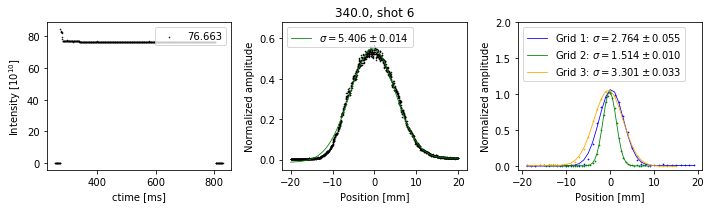

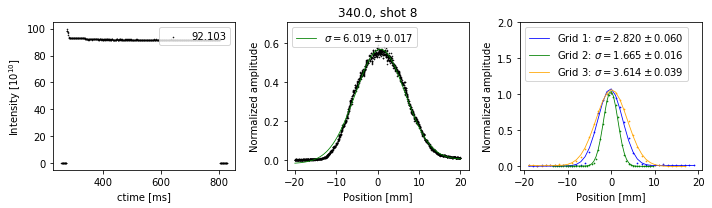

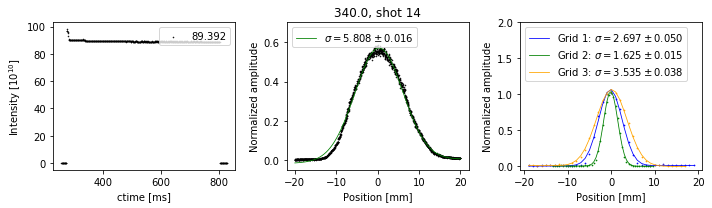

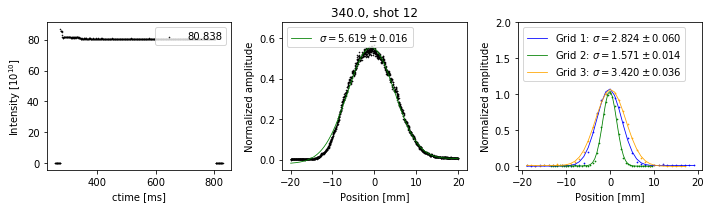

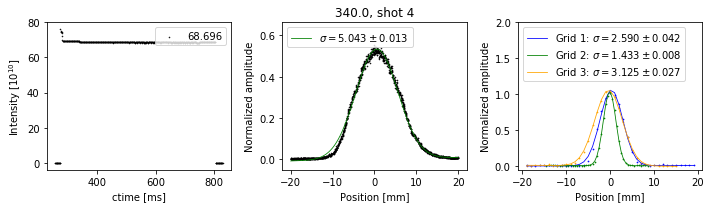

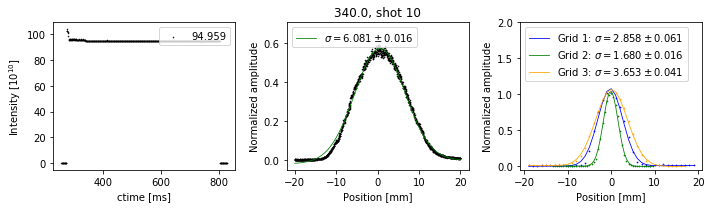

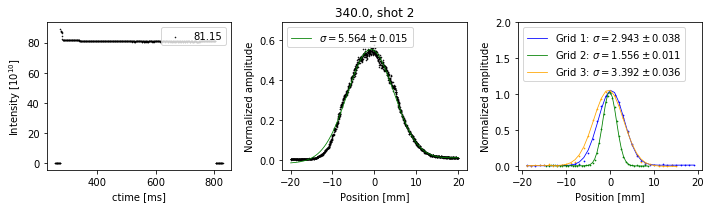

Recorded intensities: [ 76.663  92.103  89.392  80.838  68.696  94.959  81.15 ]
Intensities after outlier exclusion: [76.662999999999997, 0, 89.391999999999996, 80.838000000000008, 0, 0, 81.150000000000006]
Beta wire: 4.287341974249999
Beta rel: 0.40967 Gamma rel: 1.09621
3.06173744374 76.663
3.7949148981 0
An intensity value was excluded.
3.53325619658 89.392
3.30750020724 80.838
2.66372184338 0
An intensity value was excluded.
3.87351275587 0
An intensity value was excluded.
3.24257905213 81.15

Normal emittance: [3.0617374437383447, 3.5332561965766525, 3.3075002072392095, 3.2425790521323155] 3.28626822492 0.168653988044
Normalized emittance: [1.8716079022218912, 1.8522909728157122, 1.9174191248164265, 1.8725558665586499] 1.8784684666 0.0238979138167
Intensity: [ 76.663  92.103  89.392  80.838  68.696  94.959  81.15 ] 83.4001428571

Outliers excluded: [1.8716079022218912, 1.8522909728157122, 1.9174191248164265, 1.8725558665586499] 1.8784684666 0.0238979138167

RUN_V_PROFILE_285_V_R3_

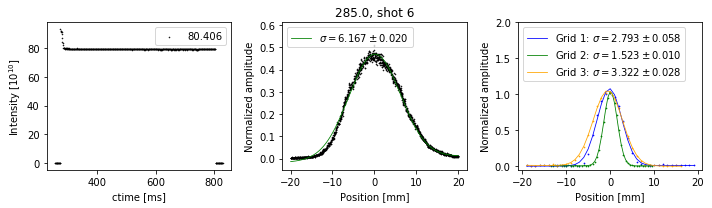

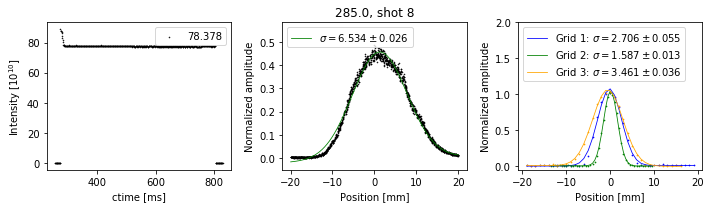

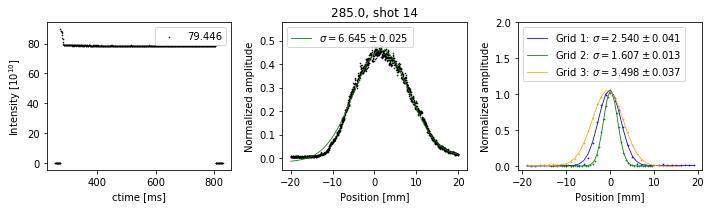

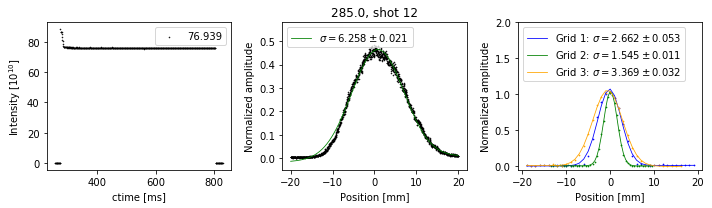

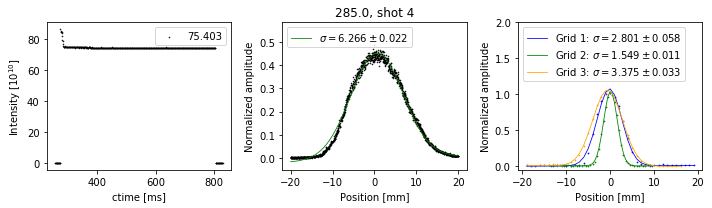

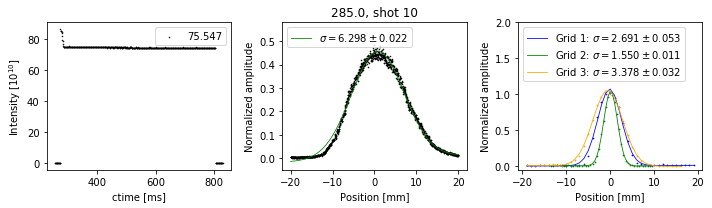

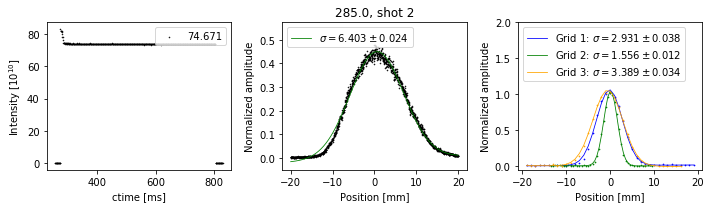

Recorded intensities: [ 80.406  78.378  79.446  76.939  75.403  75.547  74.671]
Intensities after outlier exclusion: [0, 78.378, 0, 76.939000000000007, 75.403000000000006, 75.546999999999997, 0]
Beta wire: 4.2929080274
Beta rel: 0.32403 Gamma rel: 1.05703
3.03396914921 0
An intensity value was excluded.
3.40601871495 78.378
3.52328620122 0
An intensity value was excluded.
3.12501818033 76.939
3.13224275443 75.403
3.16473001312 75.547
3.27097910185 0
An intensity value was excluded.

Normal emittance: [3.4060187149537087, 3.1250181803347363, 3.132242754425985, 3.1647300131171039] 3.20700241571 0.115871550856
Normalized emittance: [1.9013191270377032, 1.777084894780427, 1.8174771213532301, 1.8328275622693466] 1.83217717636 0.044811503691
Intensity: [ 80.406  78.378  79.446  76.939  75.403  75.547  74.671] 77.2557142857

Outliers excluded: [1.9013191270377032, 1.777084894780427, 1.8174771213532301, 1.8328275622693466] 1.83217717636 0.044811503691

RUN_V_PROFILE_350_V_R3_2018_10_19_14_38


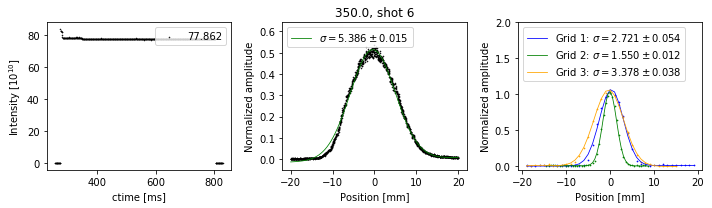

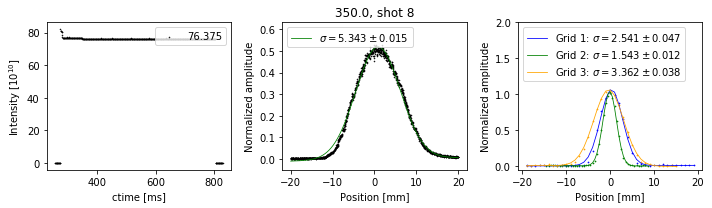

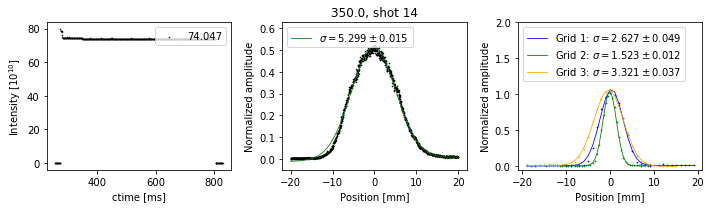

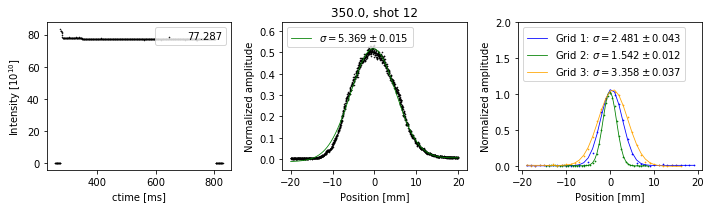

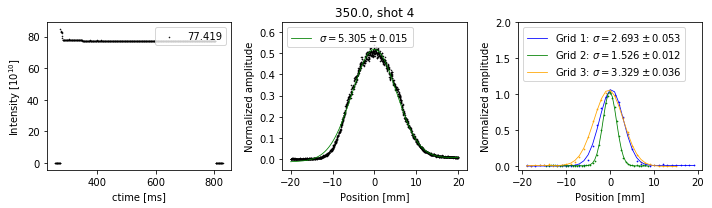

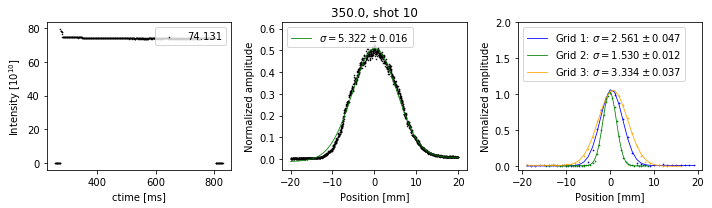

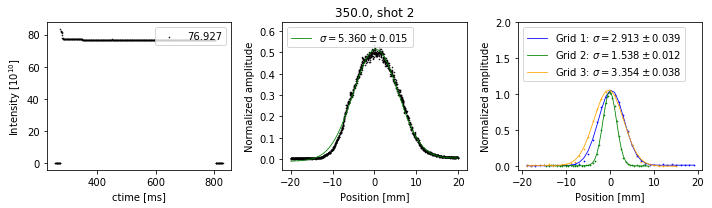

Recorded intensities: [ 77.862  76.375  74.047  77.287  77.419  74.131  76.927]
Intensities after outlier exclusion: [0, 76.375, 0, 77.287000000000006, 77.418999999999997, 0, 76.927000000000007]
Beta wire: 4.2855258898
Beta rel: 0.4273 Gamma rel: 1.10606
3.19956651979 0
An intensity value was excluded.
3.14871486093 76.375
3.09693506232 0
An intensity value was excluded.
3.1793504216 77.287
3.10390395248 77.419
3.12361930223 0
An intensity value was excluded.
3.16822240997 76.927

Normal emittance: [3.1487148609343953, 3.1793504215996244, 3.1039039524774474, 3.1682224099729717] 3.15004791125 0.0288096835759
Normalized emittance: [1.8140366927971594, 1.810072225519459, 1.7641059846783158, 1.8121778681662113] 1.80009819279 0.0208273900987
Intensity: [ 77.862  76.375  74.047  77.287  77.419  74.131  76.927] 76.2925714286

Outliers excluded: [1.8140366927971594, 1.810072225519459, 1.7641059846783158, 1.8121778681662113] 1.80009819279 0.0208273900987

RUN_V_PROFILE_300_V_R3_2018_10_19_11_56

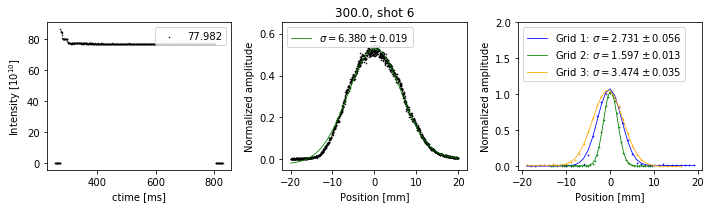

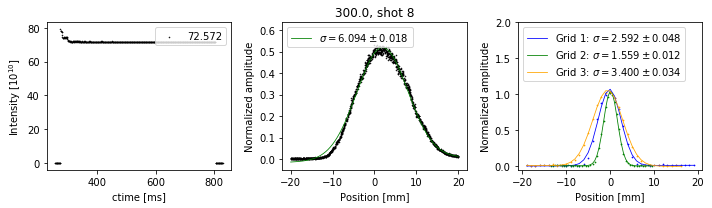

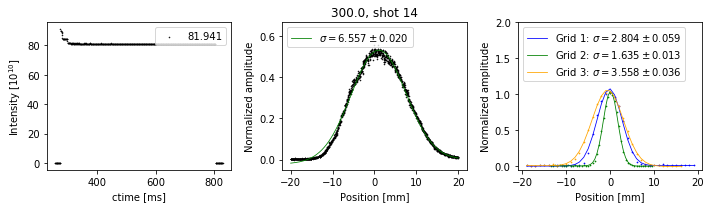

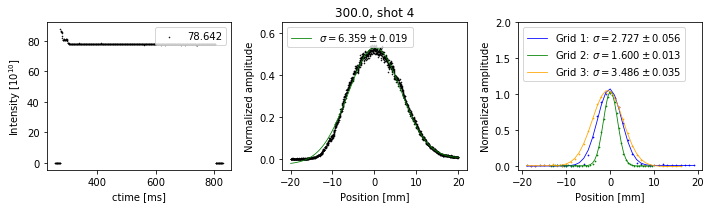

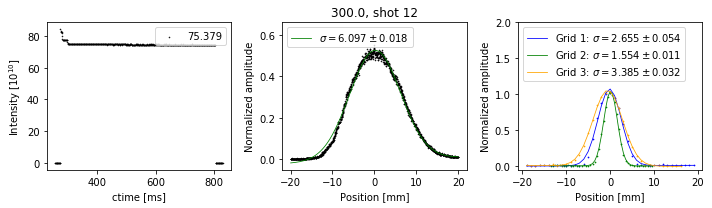

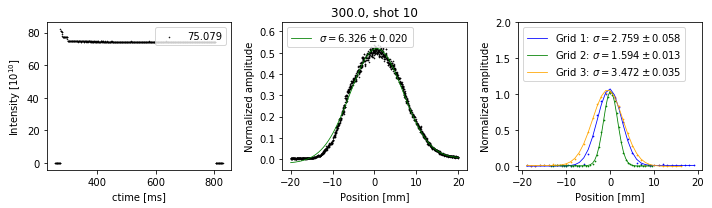

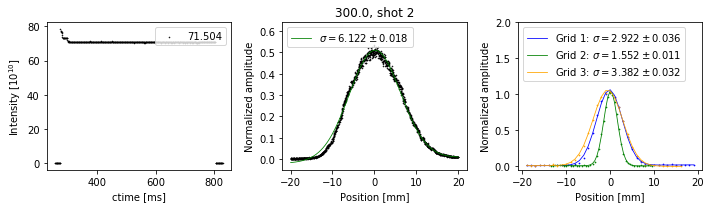

Recorded intensities: [ 77.982  72.572  81.941  78.642  75.379  75.079  71.504]
Intensities after outlier exclusion: [77.981999999999999, 0, 0, 78.641999999999996, 75.379000000000005, 75.079000000000008, 0]
Beta wire: 4.29189735005
Beta rel: 0.34446 Gamma rel: 1.06519
3.4803551875 77.982
3.17458852562 0
An intensity value was excluded.
3.67517985398 0
An intensity value was excluded.
3.45730770023 78.642
3.17793787223 75.379
3.42169511216 75.079
3.20416731103 0
An intensity value was excluded.

Normal emittance: [3.4803551875005461, 3.4573077002344603, 3.1779378722269809, 3.4216951121613892] 3.38432396803 0.12097566205
Normalized emittance: [1.9578775169508766, 1.928589527230812, 1.8494872912296636, 1.9993054524143972] 1.93381494696 0.0547870242657
Intensity: [ 77.982  72.572  81.941  78.642  75.379  75.079  71.504] 76.157

Outliers excluded: [1.9578775169508766, 1.928589527230812, 1.8494872912296636, 1.9993054524143972] 1.93381494696 0.0547870242657

RUN_V_PROFILE_325_V_R3_2018_10_19_

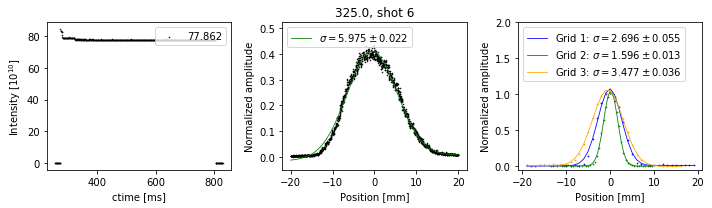

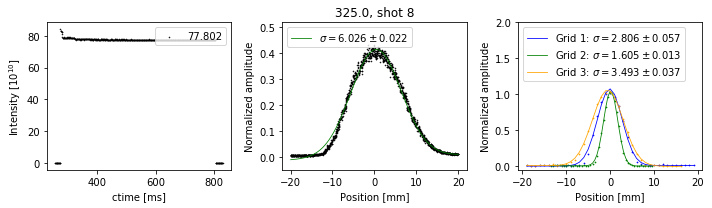

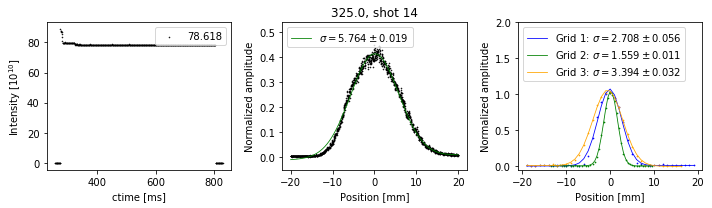

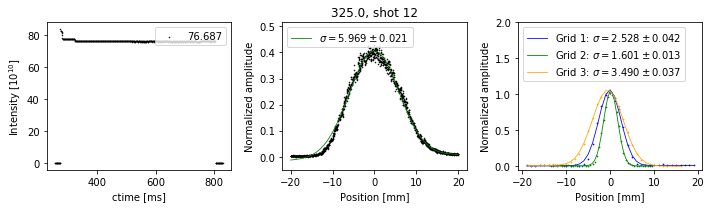

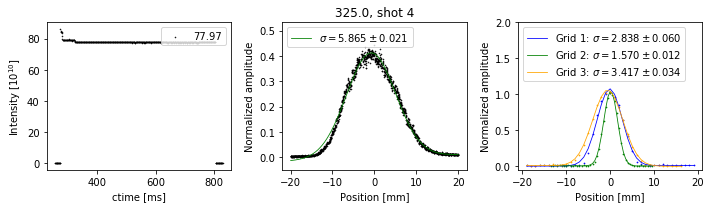

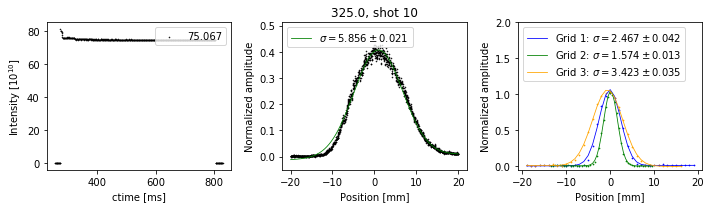

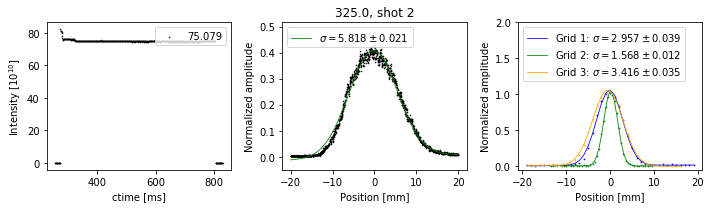

Recorded intensities: [ 77.862  77.802  78.618  76.687  77.97   75.067  75.079]
Intensities after outlier exclusion: [77.861999999999995, 77.802000000000007, 0, 76.686999999999998, 77.969999999999999, 0, 0]
Beta wire: 4.2895056593
Beta rel: 0.38404 Gamma rel: 1.08305
3.46143627664 77.862
3.52079715055 77.802
3.22177146185 0
An intensity value was excluded.
3.45447496836 76.687
3.33540618534 77.97
3.32565213179 0
An intensity value was excluded.
3.28236867198 0
An intensity value was excluded.

Normal emittance: [3.4614362766424698, 3.5207971505467337, 3.4544749683644937, 3.3354061853397994] 3.44302864522 0.0672688514461
Normalized emittance: [1.9708061640264056, 2.0061498465974306, 1.9969786770673335, 1.8964191041258212] 1.96758844795 0.0430876903255
Intensity: [ 77.862  77.802  78.618  76.687  77.97   75.067  75.079] 77.0121428571

Outliers excluded: [1.9708061640264056, 2.0061498465974306, 1.9969786770673335, 1.8964191041258212] 1.96758844795 0.0430876903255

RUN_V_PROFILE_500_V_R3_2

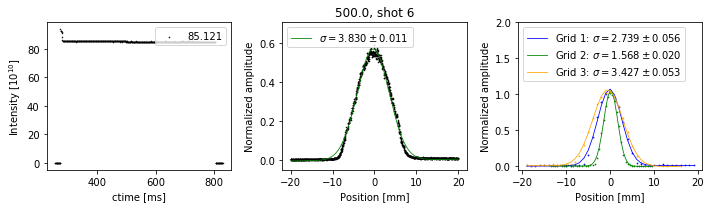

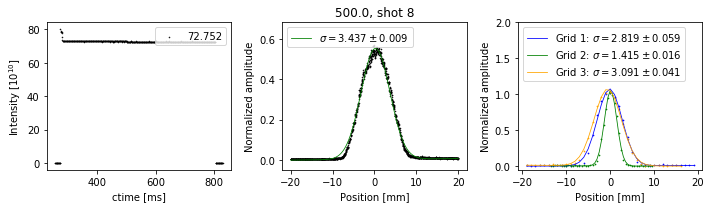

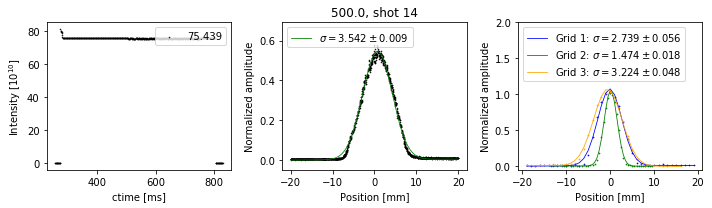

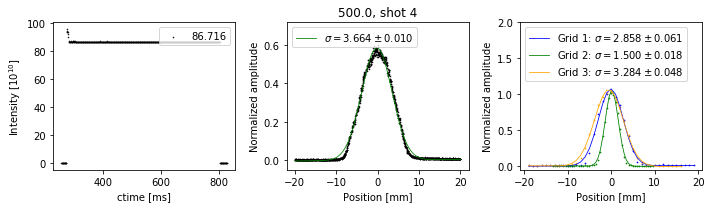

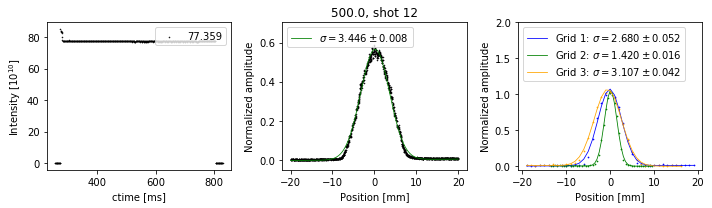

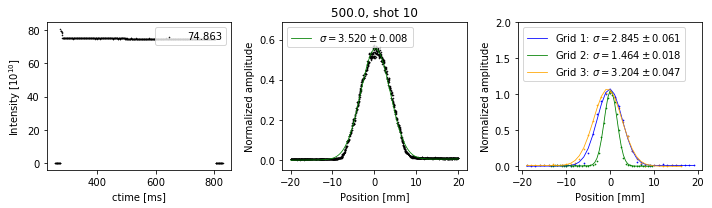

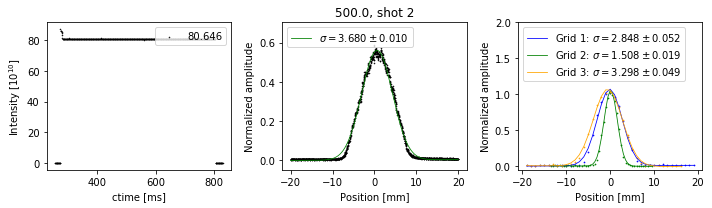

Recorded intensities: [ 85.121  72.752  75.439  86.716  77.359  74.863  80.646]
Intensities after outlier exclusion: [0, 0, 75.439000000000007, 0, 77.358999999999995, 74.863, 80.646000000000001]
Beta wire: 4.2824240149
Beta rel: 0.71309 Gamma rel: 1.42638
3.48330668007 0
An intensity value was excluded.
2.80528164523 0
An intensity value was excluded.
2.97954334707 75.439
3.18872548101 0
An intensity value was excluded.
2.81964519236 77.359
2.94223527303 74.863
3.21616840328 80.646

Normal emittance: [2.9795433470735442, 2.8196451923565968, 2.9422352730251338, 3.216168403283906] 2.98939805393 0.14366825372
Normalized emittance: [1.7395588691453703, 1.6053471483046304, 1.7309938159811158, 1.7564722577884497] 1.7080930228 0.0600246010367
Intensity: [ 85.121  72.752  75.439  86.716  77.359  74.863  80.646] 78.9851428571

Outliers excluded: [1.7395588691453703, 1.6053471483046304, 1.7309938159811158, 1.7564722577884497] 1.7080930228 0.0600246010367


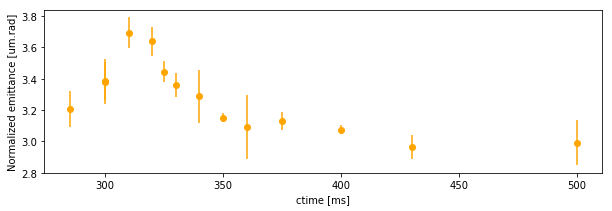

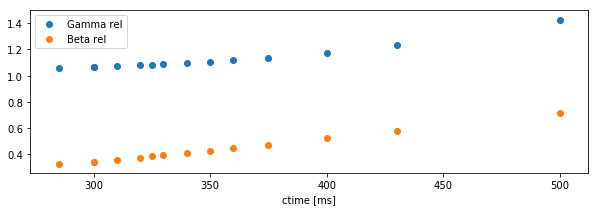

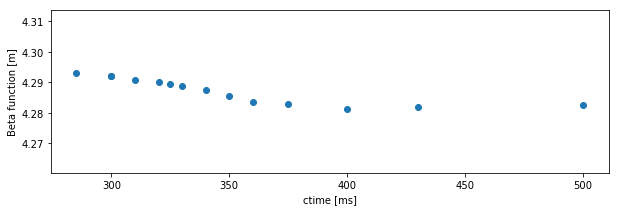

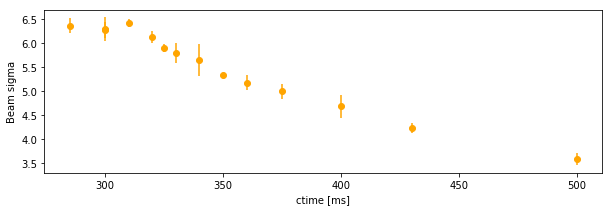

In [34]:
emittance_norm = []
error_norm = []
emittance = []
error = []
ctime = []
beta_rel = []
gamma_rel = []
sigma = []
sigma_err = []
intensity = []
intensity_err = []
beta_wire = []
for directory in result_folders:
    print("")
    print(directory)
    cycle_time = float(re.search('PROFILE_(.*)_V', directory).group(1))
    data_dict = get_data(directory, cycle_time)
    beta_w, beta, gamma, em_norm, err_norm, em, err, sig, sig_err, intt, int_err = calculate_emittance(data_dict, cycle_time, madx_folder, plane)
    emittance.append(em)
    emittance_norm.append(em_norm)
    ctime.append(cycle_time)
    error.append(err)
    error_norm.append(err_norm)
    beta_rel.append(beta)
    gamma_rel.append(gamma)
    sigma.append(sig)
    sigma_err.append(sig_err)
    intensity.append(intt)
    intensity_err.append(int_err)
    beta_wire.append(beta_w)
    

# Save the data in a file
try:
    os.remove(os.path.join(data_path, "data.txt"))
except OSError:
    pass
with open(os.path.join(data_path, "data.txt"), "a") as dfile:
    dfile.write("%10s %10s %10s %10s %10s %10s %10s %10s %10s %10s \n" % ("# ctime", "b_rel", "g_rel", "beta_y", "int", "int_err", "sigma", "sigma_err", "em", "em_err"))
    for ct, brel, grel, beta, i, i_err, s, s_err, em, err in zip(ctime, beta_rel, gamma_rel, beta_wire, intensity, intensity_err, sigma, sigma_err, emittance_norm, error_norm):
        dfile.write("%10.0f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f %10.4f \n" % (ct, brel, grel, beta, i, i_err, s, s_err, em, err))

# plt.errorbar(ctime, emittance_norm, yerr=error_norm, fmt='o', color="blue", label="Normalized to intensity")
# plt.xlabel("ctime [ms]")
# plt.ylabel("Normalized emittance [um.rad]")
# plt.title("Beam emittance in the PSB cycle")
# plt.show()

plt.errorbar(ctime, emittance, yerr=error, fmt='o', color="orange", label="Normal")
plt.xlabel("ctime [ms]")
plt.ylabel("Normalized emittance [um.rad]")
plt.show()
plt.savefig(os.path.join(data_path, "emittance.png"), dpi=1000)
plt.clf()

plt.scatter(ctime, gamma_rel, label="Gamma rel")
plt.scatter(ctime, beta_rel, label="Beta rel")
plt.xlabel("ctime [ms]")
plt.legend()
# plt.ylabel("Normalized emittance [um.rad]")
plt.show()

plt.scatter(ctime, beta_wire)
# plt.scatter(ctime, beta_rel)
plt.xlabel("ctime [ms]")
plt.ylabel("Beta function [m]")
plt.show()

plt.errorbar(ctime, sigma, yerr=sigma_err, fmt='o', color="orange")
# plt.scatter(ctime, beta_rel)
plt.xlabel("ctime [ms]")
plt.ylabel("Beam sigma")
plt.show()

A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.